In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import load_config

cfg = load_config()
DATADIR = cfg['DATA_DIR']
STIMDIR = cfg['STIM_DIR']
FIGDIR = cfg['FIG_DIR']
STORIES = cfg['STORIES']

subject = 'sub-004'
story = 'treasureisland'

tr = 1.5

In [2]:
# load roi data
from utils import load_roi, get_embeddings, downsample_embeddings_lanczos, make_delayed
xdata_stories = []
ydata_stories = []
for task in STORIES:
    roi_data, roi_labels = load_roi(DATADIR, subject, task)
    roi_labels = [label.decode('utf-8') for label in roi_labels]
    n_rois = roi_data.shape[0]

    # trim wait period (12 seconds = 8 TRs)
    ydata = roi_data[:, 8:]

    embs, starts, stops = get_embeddings(task)
    n_features = embs.shape[-1]
    xdata = downsample_embeddings_lanczos(embs, starts, stops, ydata.shape[-1], tr)

    # first, trim the data that have zero embeddings (music in the beginning, silence in the end)
    idx_valid = np.where(np.sum(xdata, axis=1) != 0)[0]
    xdata = xdata[idx_valid]
    ydata = ydata[:, idx_valid]

    # zscore each feature
    xdata = (xdata - np.mean(xdata, axis=0, keepdims=True)) / np.std(xdata, axis=0, keepdims=True)

    # shift the embeddings to account for hemodynamic delay
    n_delays = 5
    xdata = make_delayed(xdata, np.arange(1, n_delays + 1), circpad=False)

    # zscore ydata
    ydata = (ydata - np.mean(ydata, axis=1, keepdims=True)) / np.std(ydata, axis=1, keepdims=True)

    print(xdata.shape, ydata.shape)

    xdata_stories.append(xdata)
    ydata_stories.append(ydata)

[INFO] utils.load_embeddings - Loading: /Users/gio/projects/ds_fmri/data/derivatives/english1000sm.hf5


[INFO] utils.load_embeddings - data shape: (985, 10470)
[INFO] utils.load_embeddings - vocab len: 10470
[INFO] utils.get_embeddings - 1672/1763 (missing 91) story tokens found in vocab.
[INFO] utils.load_embeddings - Loading: /Users/gio/projects/ds_fmri/data/derivatives/english1000sm.hf5
[INFO] utils.load_embeddings - data shape: (985, 10470)
[INFO] utils.load_embeddings - vocab len: 10470


(546, 4925) (200, 546)


[INFO] utils.get_embeddings - 1498/1504 (missing 6) story tokens found in vocab.
[INFO] utils.load_embeddings - Loading: /Users/gio/projects/ds_fmri/data/derivatives/english1000sm.hf5
[INFO] utils.load_embeddings - data shape: (985, 10470)
[INFO] utils.load_embeddings - vocab len: 10470


(390, 4925) (200, 390)


[INFO] utils.get_embeddings - 1514/1592 (missing 78) story tokens found in vocab.
[INFO] utils.load_embeddings - Loading: /Users/gio/projects/ds_fmri/data/derivatives/english1000sm.hf5
[INFO] utils.load_embeddings - data shape: (985, 10470)
[INFO] utils.load_embeddings - vocab len: 10470


(360, 4925) (200, 360)


[INFO] utils.get_embeddings - 2665/2675 (missing 10) story tokens found in vocab.
[INFO] utils.load_embeddings - Loading: /Users/gio/projects/ds_fmri/data/derivatives/english1000sm.hf5
[INFO] utils.load_embeddings - data shape: (985, 10470)
[INFO] utils.load_embeddings - vocab len: 10470


(550, 4925) (200, 550)


[INFO] utils.get_embeddings - 2018/2127 (missing 109) story tokens found in vocab.
[INFO] utils.load_embeddings - Loading: /Users/gio/projects/ds_fmri/data/derivatives/english1000sm.hf5
[INFO] utils.load_embeddings - data shape: (985, 10470)
[INFO] utils.load_embeddings - vocab len: 10470


(530, 4925) (200, 530)


[INFO] utils.get_embeddings - 1874/1964 (missing 90) story tokens found in vocab.


(485, 4925) (200, 485)


In [4]:
# regression; leave-one-story-out
from sklearn.linear_model import RidgeCV
from ridge import bootstrap_ridge

n_stories = len(STORIES)
alphas = np.logspace(-3, 3, 7)
nboots = 1 # Number of cross-validation runs.
chunklen = 40 # 
nchunks = 20

weights = np.zeros((n_stories, n_rois, n_features * n_delays))
encperf = np.zeros((n_stories, n_rois))

for i in range(n_stories):
    xdata_train = np.concatenate(xdata_stories[:i] + xdata_stories[i + 1:])
    ydata_train = np.concatenate(ydata_stories[:i] + ydata_stories[i + 1:], axis=1)
    xdata_test = xdata_stories[i]
    ydata_test = ydata_stories[i]

    print(xdata_train.shape, ydata_train.shape, xdata_test.shape, ydata_test.shape)

    wt, corr, alphas, bscorrs, valinds = bootstrap_ridge(xdata_train, ydata_train.T, xdata_test, ydata_test.T,
                                                     alphas, nboots, chunklen, nchunks,
                                                     singcutoff=1e-10, single_alpha=True)



    encperf[i] = corr


(2315, 4925) (200, 2315) (546, 4925) (200, 546)
(2471, 4925) (200, 2471) (390, 4925) (200, 390)
(2501, 4925) (200, 2501) (360, 4925) (200, 360)
(2311, 4925) (200, 2311) (550, 4925) (200, 550)
(2331, 4925) (200, 2331) (530, 4925) (200, 530)
(2376, 4925) (200, 2376) (485, 4925) (200, 485)


17Networks_LH_VisCent_Striate_1: 0.12604310862581958
17Networks_LH_VisPeri_ExStrSup_2: 0.1010214049994997
17Networks_LH_DefaultC_IPL_1: 0.1005937599896295
17Networks_LH_SomMotA_1: 0.0892829918695286
17Networks_RH_SalVentAttnB_PFCl_1: 0.08776709347486335


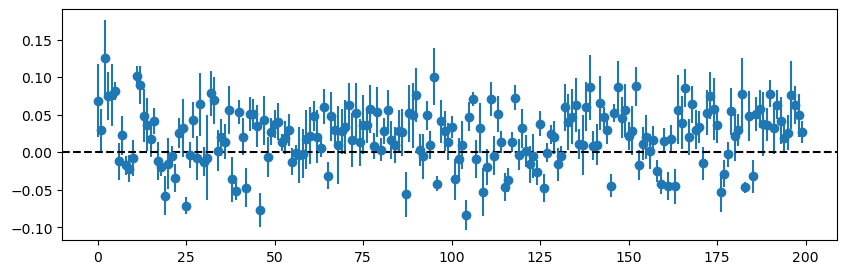

In [5]:
# plot mean and sem of encoding performance
plt.figure(figsize=(10, 3))
plt.errorbar(np.arange(len(roi_labels)), np.mean(encperf, axis=0), np.std(encperf, axis=0) / np.sqrt(n_stories), fmt='o')
plt.axhline(0, color='k', linestyle='--')

mean_encperf = np.mean(encperf, axis=0)
# print top 5 ROIs with highest mean encoding performance
top5 = np.argsort(np.mean(encperf, axis=0))[::-1][:5]
for i in range(5):
    print(f'{roi_labels[top5[i]]}: {np.mean(encperf, axis=0)[top5[i]]}')

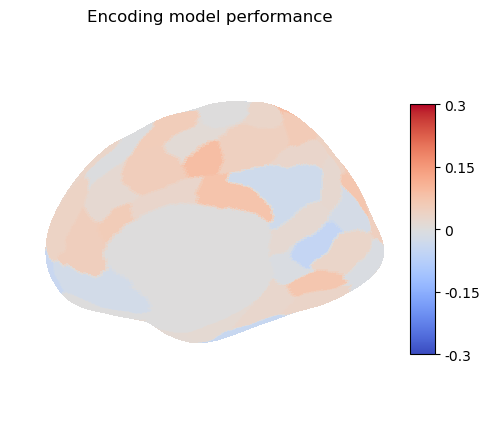

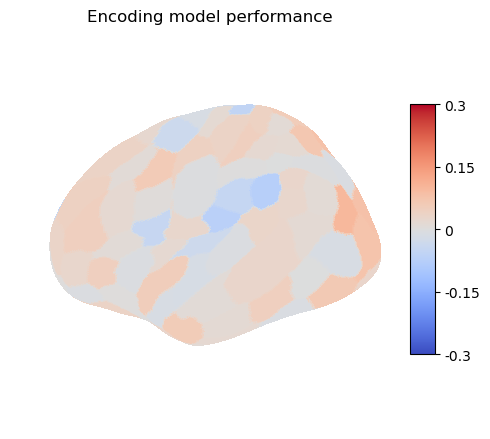

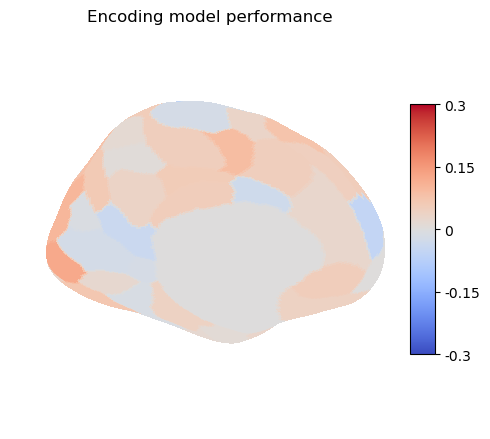

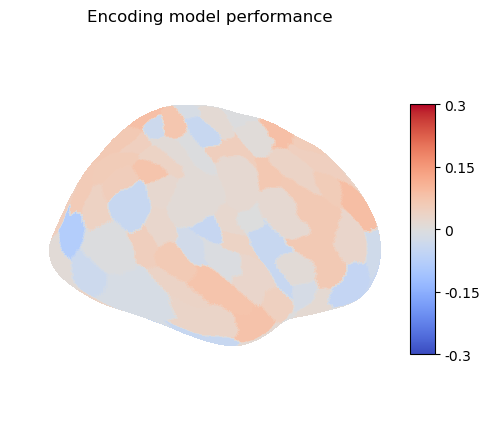

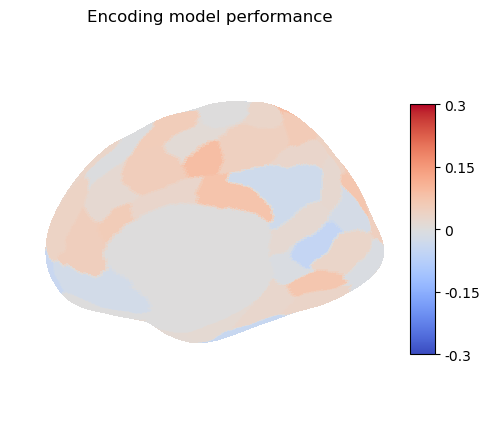

In [6]:
# plot encoding model performance on the brain
import nibabel as nib
from nilearn import datasets, plotting

fsaverage = datasets.fetch_surf_fsaverage(mesh='fsaverage6')

# left hemisphere
surf_labels, ctab, surf_names = nib.freesurfer.read_annot('/Users/gio/Downloads/lh.Schaefer2018_200Parcels_17Networks_order.annot')
surf_labels = surf_labels.astype(int)
surf_names = [name.decode('utf-8') for name in surf_names]

surf_score = np.zeros_like(surf_labels, dtype=float)
for ivertex, vertex_label in enumerate(surf_labels):
    if vertex_label == 0:
        continue
    roi_idx = roi_labels.index(surf_names[vertex_label])
    surf_score[ivertex] = mean_encperf[roi_idx]

plotting.plot_surf_stat_map(fsaverage.infl_left, surf_score, hemi='left', title='Encoding model performance', colorbar=True, cmap='coolwarm', vmax=0.3, vmin=-0.3)

plotting.plot_surf_stat_map(fsaverage.infl_left, surf_score, hemi='left', title='Encoding model performance', colorbar=True, cmap='coolwarm', vmax=0.3, vmin=-0.3, view='medial')

# plt.savefig(os.path.join(FIGDIR, 'surf_isc_roi_R.png'))

# right hemisphere
surf_labels, ctab, surf_names = nib.freesurfer.read_annot('/Users/gio/Downloads/rh.Schaefer2018_200Parcels_17Networks_order.annot')
surf_labels = surf_labels.astype(int)
surf_names = [name.decode('utf-8') for name in surf_names]

surf_score = np.zeros_like(surf_labels, dtype=float)
for ivertex, vertex_label in enumerate(surf_labels):
    if vertex_label == 0:
        continue
    roi_idx = roi_labels.index(surf_names[vertex_label])
    surf_score[ivertex] = mean_encperf[roi_idx]

plotting.plot_surf_stat_map(fsaverage.infl_right, surf_score, hemi='right', title='Encoding model performance', colorbar=True, cmap='coolwarm', vmax=0.3, vmin=-0.3)

plotting.plot_surf_stat_map(fsaverage.infl_right, surf_score, hemi='right', title='Encoding model performance', colorbar=True, cmap='coolwarm', vmax=0.3, vmin=-0.3, view='medial')
